### MACS 33002-2022S Machine Learning Individual Project

Dataset:
https://www.kaggle.com/datasets/kevinarvai/clinvar-conflicting

### Introduction and Background
The human genome is widely varied across popualtions. Each gene contains mutations and variants that occur in different prevalances. These variants are tracked online through ClinVar, a public database with annotations on different human genetic variants. Different variants have different affects humans. For example, some cause disease on their own (sickle cell anemia, cystic fibrosis), some work with other factors (complex diseases such as autism, heart disease) to cause a disease, and some are effectively harmless. As more research is performed, a better understanding of genetic mutations and their affects can lead to better prevention, diagnoses, and treatment.

Variants can be clinically classified into either benign, likely benign, uncerain significance, likely pathogenic, and pathogenic. Classification on ClinVar usually occurs manually. However, the human genome is extremely multifaceted, and genes can have different affects in different contexts. A full understanding of genetics is far away. Consequently, clinicians and researchers may classify a single variant differently, leading to confusion when people using ClinVar as a medical reference try to interpret the impact of a variant. 

### Objective
Use the given data to predict whether a gene variant will have conflicting classifications. In this case, we will consider "benign" and "likely benign" together, as well as "pathogenic" and "likely pathogenic."

In [1]:
# Import libraries, functions, set base preferances
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style(style='whitegrid')
import matplotlib.pyplot as plt
from matplotlib import pylab
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import base
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
!pip install category_encoders
from category_encoders import BinaryEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score,roc_auc_score,classification_report,confusion_matrix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Data Visualization and Exploration:

While ideally we would not perform any data modifying, as we have not yet split the data into train/validation/test and modifying all the data would introduct data leakage into the validation/test pools, it is difficult to apply modified data to both train/test samples, so we will knowingly accept that there may be some data leakage. 

In [2]:
#load data
data = pd.read_csv("clinvar_conflicting.csv")
# view shape to ensure proper loading and 
print("Data shape:", data.shape) #og 65188

Data shape: (65188, 46)


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,38,40) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
#data visualization
data.head()

,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDISDBINCL,CLNDN,...,SIFT,PolyPhen,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62
0,1,1168180,G,C,0.0771,0.10020,0.1066,MedGen:CN169374,NaN,not_specified,...,tolerated,benign,NaN,NaN,NaN,NaN,NaN,1.053,-0.208682,2.0
1,1,1470752,G,A,0.0000,0.00000,0.0000,"MedGen:C1843891,OMIM:607454,Orphanet:ORPHA9877...",NaN,Spinocerebellar_ataxia_21|not_provided,...,deleterious_low_confidence,benign,NaN,NaN,NaN,NaN,NaN,31.000,6.517838,-3.0
2,1,1737942,A,G,0.0000,0.00001,0.0000,"Human_Phenotype_Ontology:HP:0000486,MedGen:C00...",NaN,Strabismus|Nystagmus|Hypothyroidism|Intellectu...,...,deleterious,probably_damaging,NaN,NaN,NaN,NaN,NaN,28.100,6.061752,-1.0
3,1,2160305,G,A,0.0000,0.00000,0.0000,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002...",NaN,Shprintzen-Goldberg_syndrome|not_provided,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.500,3.114491,NaN
4,1,2160305,G,T,0.0000,0.00000,0.0000,"MedGen:C1321551,OMIM:182212,SNOMED_CT:83092002",NaN,Shprintzen-Goldberg_syndrome,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.700,4.766224,-3.0


Feature types:
- CHROM = chromsome the variant is located on
- POS = variant's position on chromosome
- REF = reference allele (non mutated)
- ALT = alternate allele (mutated)
- AF_ESP = allele frequencies from GO-ESP
- AF_EXAC = allele freq from ExAC
- AF_TGP = allele freq from 1000 genomes proj
- CLNDISDB = description of disease associated with the variant. Stored as a tag-value pair of disease database name and identifier. Within one variable entry, different diseases are separated by "|", different databases within the same disease separated by ",". 
- CLNDISDBINCL = for included variant, the above (all values = nan)
- CLNDN = ClinVar's prefered disease name for the concept specified by disease identifiers in CLNDISDB. 
- CLNDNINCL = for included variant, the above (all values = nan)
- CLNHGVS = a valid HGVS expression based on top-level genomic sequences (assembled chromosomes, mitochondrion,  or alternate loci or patches).
- CLNSIGINCL = clinical significance for a haplotype or genotype that includes this variant (all values = nan)
- CLNVI = variant type (SNV, deletion, other, etc.)
- CLNVI = clinical sources stored as tag-value pairs of database:variant identifier (most nan)
- MC = comma separated list of molecular consequences in the form of sequence ontology ID|molecular_consequence
- ORIGIN = allele origin. 0 - unknown; 1 - germline; 2 - somatic; 4 - inherited; 8 - paternal; 16 - maternal; 32 - de-novo; 64 - biparental; 128 - uniparental; 256 - not-tested; 512 - tested-inconclusive; 1073741824 - other
- SSR = variant suspect reason codes. One of more of the following: 0 - unspecified, 1 - Paralog, 2 - byEST, 4 - oldAlign, 8 - Para_EST, 16 - 1kg_failed, 1024 - other
- CLASS = target variable (see below)
- Allele = variant allele used to calculate the conseqeunce
- Consequence = type of variant consequence, such as "splice_donor_variant," "stop_lost", "missense_variant", or "intron_variant"
- IMPACT = subjective classification of the severity of variant consequence, based on SNPEff stored as LOW, MODERATE, etc.
- SYMBOL = Gene name
- Feature_type = Transcript, RegulatoryFeature, MotifFeature
- Feature = Ensembl stable ID of feature
- BIOTYPE = all protein_coding? 
- EXON = exon number (out of total number) (14% [null])
- INTRON = intron number (out of total number) (86% [null])
- cDNA_position = relative position of base pair in cDNA sequence
- CDS_position = relative position of base pair in coding sequence
- Protein_position = relative pos of amino acid in protein
- Amino_acids = affected amino acids, [null] if variant doesn't affect protein-coding seq
- Codons = alternative codons with variant base in uppercase (ex cGg/cAg)
- DISTANCE = shortest distance from variant to transcript (100% [null]?)
- STRAND = forward (+), reverse (-)
- BAM_EDIT = success/failure of edit using a BAM file (51% [null], 49% "OK")
- SIFT = SIFT (Sorting Intolerant from Tolerant alg) prediction and/or score. Predicts effect of coding vars on protein function. Mostly [null], some "deleterious", some other. 
- PolyPhen = PolyPhen prediction and/or score
- MOTIF_NAME = source and identifier of transcription factor binding profile (TFBP) aligned at this position (100% [null])
- MOTIF_POS = relative position of variation in algined TFBP (100% [null])
- HIGH_INF_POS = flag indicating if variant falls in high information position of a TFBP (100% [null])
- MOTIF_SCORE_CHANGE = diffreence in motif score of regerence and variant seq for TFBP (100% [null])
- LoFtool = LOF tolerance score for LOF variants 
- CADD_PHRED = Phred-scaled CADD (combined annotation dependent depletion) score. Predicts varient effect. (Phred score estimates the probability a NT base was sequenced incorrectly. Higher q-score = more confidence.)
- CADD_RAW = score of deleteriousness (harm) of variants
- BLOSUM62 = assignment of alignment score to subsituted amino acids caused by variants


Target variable:
- binary (0 = consistent classification, 1 = conflicting classifications)

In [4]:
#data type and null value info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 46 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CHROM               65188 non-null  object 
 1   POS                 65188 non-null  int64  
 2   REF                 65188 non-null  object 
 3   ALT                 65188 non-null  object 
 4   AF_ESP              65188 non-null  float64
 5   AF_EXAC             65188 non-null  float64
 6   AF_TGP              65188 non-null  float64
 7   CLNDISDB            65188 non-null  object 
 8   CLNDISDBINCL        167 non-null    object 
 9   CLNDN               65188 non-null  object 
 10  CLNDNINCL           167 non-null    object 
 11  CLNHGVS             65188 non-null  object 
 12  CLNSIGINCL          167 non-null    object 
 13  CLNVC               65188 non-null  object 
 14  CLNVI               27659 non-null  object 
 15  MC                  64342 non-null  object 
 16  ORIG

In [5]:
data.describe()

,POS,AF_ESP,AF_EXAC,AF_TGP,ORIGIN,SSR,CLASS,DISTANCE,STRAND,MOTIF_POS,MOTIF_SCORE_CHANGE,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62
count,6.518800e+04,65188.000000,65188.000000,65188.000000,65188.000000,130.000000,65188.000000,108.000000,65174.000000,2.0,2.000000,60975.000000,64096.000000,64096.000000,25593.000000
mean,7.757594e+07,0.014511,0.014492,0.015263,1.342486,2.269231,0.252102,825.731481,-0.006659,1.0,-0.080000,0.345058,15.685616,2.554131,-0.402258
std,5.974051e+07,0.057795,0.059542,0.059527,5.688772,4.190777,0.434223,1069.363315,0.999985,0.0,0.024042,0.361238,10.836350,2.961553,1.872684
min,9.610000e+02,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,-1.000000,1.0,-0.097000,0.000069,0.001000,-5.477391,-3.000000
25%,3.254179e+07,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,55.500000,-1.000000,1.0,-0.088500,0.024300,7.141000,0.462951,-2.000000
50%,5.797021e+07,0.000000,0.000040,0.000000,1.000000,1.000000,0.000000,469.000000,-1.000000,1.0,-0.080000,0.157000,14.090000,1.642948,-1.000000
75%,1.127454e+08,0.001200,0.001230,0.001600,1.000000,1.000000,1.000000,1415.000000,1.000000,1.0,-0.071500,0.710000,24.100000,4.381392,1.000000
max,2.476080e+08,0.499000,0.499890,0.499800,513.000000,16.000000,1.000000,4759.000000,1.000000,1.0,-0.063000,1.000000,99.000000,46.556261,3.000000


Now we may consider each attribute and if the data representation for each is suited for use in an ML model. 
In order to see correlations via a heatmap, we need to encode values as numbers.

cDNA_position, CDS_position, and Protein_position are stored as an object because they are represented as ranges. We may encode them as a single number to essentially represent the start position. 

In [6]:
#Encode cDNA_position, CDS_position, Protein_position to represent a single number instead of a span of numbers (ex. "100-102")
data.insert(0,"KEY",data.CLNHGVS)

def singlenum(data, columns):
  for i in columns:
    singlenum = pd.DataFrame(data[i][data[i].notnull()].str.split("-").tolist(), columns=['X', 'Y'])
    singlenum['X'][singlenum['X'] == '?'] = singlenum['Y']
    
    key = data[[i,"KEY"]][data[i].notnull()]["KEY"]
    count = 0
    for j in key.index:
      data[i][j] = singlenum['X'][count]
      count += 1
    data[i] = data[i].astype(float)
  return data

data = singlenum(data, ['cDNA_position', 'CDS_position', 'Protein_position'])
print('cDNA_position unique values:', data['cDNA_position'].unique())
print('CDS_position unique values:', data['CDS_position'].unique())
print('Protein position unique values:', data['Protein_position'].unique())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


cDNA_position unique values: [ 552.  523.  632. ... 8028. 6765. 5959.]
CDS_position unique values: [ 522.  509.  239. ... 4737. 4447. 4232.]
Protein position unique values: [ 174.  170.   80. ... 3228. 3162. 2992.]


Exon/Intron data is stored as objects and represented as "number/number", but it can be represented as a float. 

In [7]:
#exon/intron conversion to float
def converttofloat(data, columns):
  for col in columns:
    converttofloat = pd.DataFrame(data[col][data[col].notnull()].str.split("/").tolist(),columns=["num","denom"])
    converttofloat = converttofloat.astype("float")
    converttofloat["Result"] = converttofloat["num"] / converttofloat["denom"]
    key = data[[col,"KEY"]][data[col].notnull()]["KEY"]

    count = 0
    for i in key.index:
      data[col][i] = converttofloat["Result"][count]
      count += 1
    data[col] = data[col].astype(float)
  return data

data = converttofloat(data, ['INTRON','EXON'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [8]:
#encode Molecular Consequence attribute (MC = seq ontology ID|molecular consequence)
#drop null values, split types of molecular consequences
MC_list = data['MC'].dropna().str.split(',').apply(lambda row: list((c.split('|')[1] for c in row)))
MC_encoded = pd.get_dummies(MC_list.apply(pd.Series).stack()).sum(level=0)
MC_encoded = MC_encoded.reindex(index=MC_list.index)

data = data.join(MC_encoded).drop(columns=['MC'])

MC_encoded.head()

#We'll have to manually encode this into the feature matrix

#Also, drop 'Consequence' as it has the same values. 
data.drop(['Consequence'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  after removing the cwd from sys.path.


In [9]:
#ordinally encode SIFT and PolyPhen
data = pd.get_dummies(data, columns=['SIFT', 'PolyPhen'])
data.columns

Index(['KEY', 'CHROM', 'POS', 'REF', 'ALT', 'AF_ESP', 'AF_EXAC', 'AF_TGP',
       'CLNDISDB', 'CLNDISDBINCL', 'CLNDN', 'CLNDNINCL', 'CLNHGVS',
       'CLNSIGINCL', 'CLNVC', 'CLNVI', 'ORIGIN', 'SSR', 'CLASS', 'Allele',
       'IMPACT', 'SYMBOL', 'Feature_type', 'Feature', 'BIOTYPE', 'EXON',
       'INTRON', 'cDNA_position', 'CDS_position', 'Protein_position',
       'Amino_acids', 'Codons', 'DISTANCE', 'STRAND', 'BAM_EDIT', 'MOTIF_NAME',
       'MOTIF_POS', 'HIGH_INF_POS', 'MOTIF_SCORE_CHANGE', 'LoFtool',
       'CADD_PHRED', 'CADD_RAW', 'BLOSUM62', '2KB_upstream_variant',
       '3_prime_UTR_variant', '500B_downstream_variant', '5_prime_UTR_variant',
       'frameshift_variant', 'intron_variant', 'missense_variant', 'nonsense',
       'splice_acceptor_variant', 'splice_donor_variant', 'synonymous_variant',
       'SIFT_deleterious', 'SIFT_deleterious_low_confidence', 'SIFT_tolerated',
       'SIFT_tolerated_low_confidence', 'PolyPhen_benign',
       'PolyPhen_possibly_damaging', 'PolyP

In [49]:
#Encode REF, ALT, Allale with label encoder
le = LabelEncoder()
ref_enc = le.fit_transform(X_train_scaled['REF'])
alt_enc = le.fit_transform(X_train_scaled['ALT'])
allele_enc = le.fit_transform(X_train_scaled['Allele'])
ref_test_enc = le.fit(X_test['REF'])
alt_test_enc = le.fit(X_test['ALT'])
allele_test_enc = le.fit(X_test['Allele'])
print(ref_enc)
print(alt_enc)
print(allele_enc)

X_train_scaled['REF'] = ref_enc
X_train_scaled['ALT'] = alt_enc
X_train_scaled['Allele'] = allele_enc
X_test['REF'] = ref_test_enc
X_test['ALT'] = alt_test_enc
X_test['Allele'] = allele_test_enc

[63 54 66 ... 64 61 64]
[55 39 55 ... 50 47 42]
[31 19 31 ... 28 26 22]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7eff5e9479d0>,
      dtype=object)

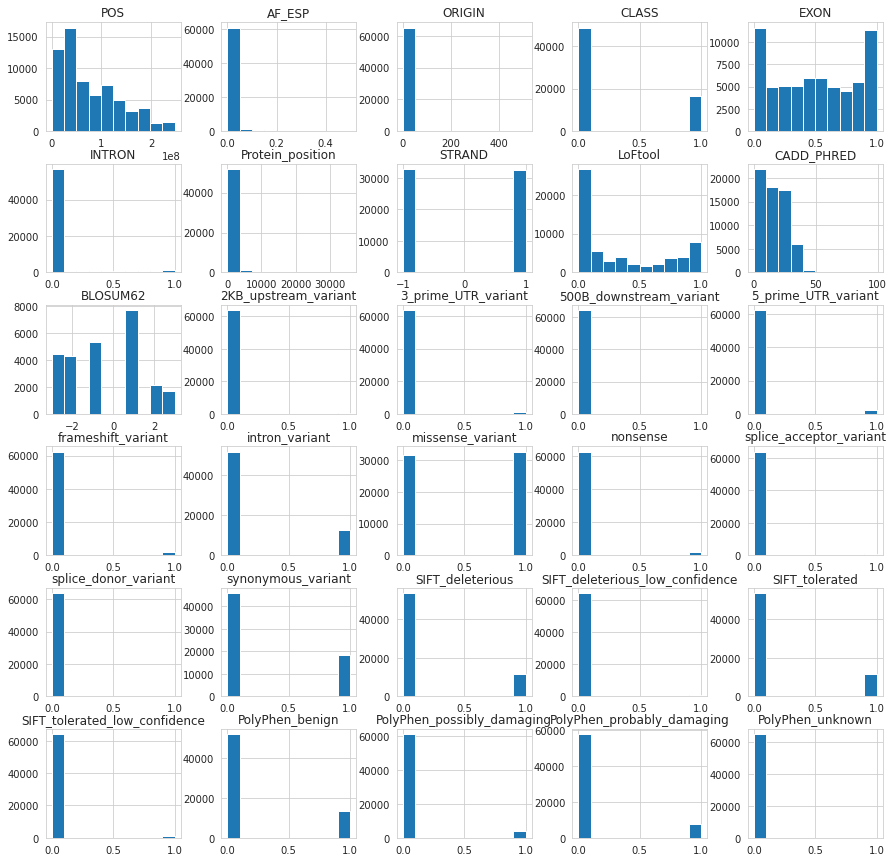

In [50]:
#create numerical data distribution histograms
data.hist(figsize=(15,15))

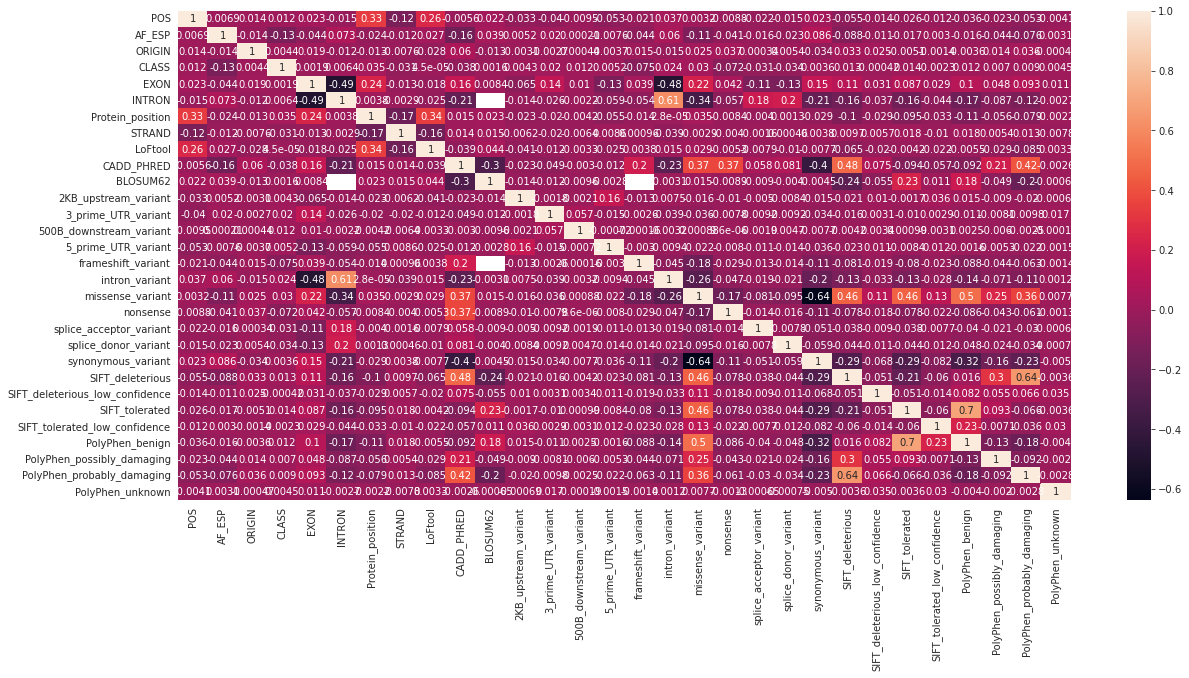

In [51]:
#Correlaion Heatmap of data
f, ax = plt.subplots(figsize=(20, 9))
sns.heatmap(data.corr(), annot=True)
plt.show()

We see high correlation between:
- AF_TGP, AF_ESP, and AF_EXAC. Therefore we will remove AF_TGP and AF_EXAC during data preprocessing. 
- cDNA_position, CDS_position, and Protein_position. Therefore we will remove cDNA_position, CDS_position. 
- CADD_PHRED and CADD_RAW. Therefore, we will remove CADD_RAW, to consider the phred score in the model. 
- EXON and INTRON. Therefore, we'll combine the two into one variable. 

The dataframe has three sets of allele frequency reportings -- one from GO-ESP, one from ExAC, and one from the 1000s genomes project. Let's compare them to see if there are discrepancies. 

It also has two different scores (or predicted score, but there isn't a good way to differenciate) from different algorithms for protein function with said variant. However, we can't compare them as they're categorical variable. We will compare them in the train set after train/validation/test split.  

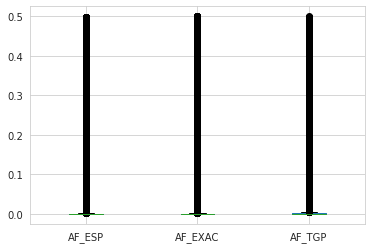

In [12]:
#compare allele frequencies:
data.boxplot(column=['AF_ESP', 'AF_EXAC', 'AF_TGP'])

While there are a lot of outliers here, it's biologically correct that there are significant amounts of genes that have significantly higher mutated allele frequencies. We will deal with outliers below. 

Look at varient types: CLNVC

In [13]:
varient = pd.crosstab(data.CLNVC, data.CLASS, margins=True)
varient = varient.drop('All', axis=0)
varient = varient.sort_values(by='All', ascending=False)
print('Varient types:')
varient

Varient types:


CLASS,0,1,All
CLNVC,,,
single_nucleotide_variant,45578,15703,61281
Deletion,2057,452,2509
Duplication,816,218,1034
Indel,207,40,247
Insertion,81,14,95
Inversion,13,4,17
Microsatellite,2,3,5


Text(0.5, 1.0, 'Histogram of Binary Target Categories')

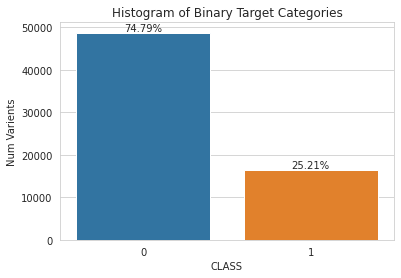

In [14]:
# Check target label distribution
ax = sns.countplot(x="CLASS", data=data)
ax.set(xlabel='CLASS', ylabel='Num Varients')
for i in ax.patches: 
  x=i.get_bbox().get_points()[:,0]
  y=i.get_bbox().get_points()[1,1]
  ax.annotate('{:.2f}%'.format(100.*y/len(data)), (x.mean(), y), ha='center', va='bottom') 
plt.title('Histogram of Binary Target Categories')

There's over 2x more consistent data than conflicting data -- the CLASS dist is skewed to the 0 class. However, there is a significant amount of data available, enough that the model may be able to train well on skewed data. We will analyze the classifier's ability to identify true positive and true negative instances correctly after model training/testing, and determine if other preprocessing is needed. 

Are conflicting variants more common in some genes? 

In [15]:
gene = pd.crosstab(data.SYMBOL, data.CLASS, margins=True)
gene = gene.drop('All', axis=0)
gene = gene.sort_values(by='All', ascending=False).head(50)
print('Gene list with conflicting variants:')
gene

Gene list with conflicting variants:


CLASS,0,1,All
SYMBOL,,,
TTN,1877,888,2765
BRCA2,1352,582,1934
ATM,1691,218,1909
APC,1057,171,1228
BRCA1,729,346,1075
MSH6,931,117,1048
LDLR,614,291,905
PALB2,701,93,794
NF1,656,76,732


### Data Preprocessing:

It's difficult to remove samples from both X and y train/validation/test feature matrices during preprocessing. While removing data/encoding data technically alters data, it can be assumed that this preprocessing can occur in all cases. We will preprocess data first, and then train/test split. 

**Missing Values:**

We will remove any value that doesn't have a gene name attached to it ('SYMBOL[i]=[null]'). 

We cannot impute numbers for exon and intron, but we can replace the [null] status with a 0. 

Finally, we will calculate % missing values for all attributes. Features with missing values over 99%, will not provide useful information to the classifier, so we will remove those features. 

In [16]:
#compute percentage [null] data in all attributes
def NullStats(data):
  var_names = []
  nullvalue_pclist = []
  for i in data.columns:
    var_names.append(i)
    nullvalue_pc = round((data[i].isna().sum()/len(data[i])),4)
    nullvalue_pclist.append(nullvalue_pc)
  nullvalue_df = pd.DataFrame({'Variable':var_names, '% Null Values':nullvalue_pclist})
  return nullvalue_df.sort_values(by='% Null Values', ascending=False)

nullvalues = NullStats(data)
nullvalues = nullvalues.set_index("Variable")
nullvalues

,% Null Values
Variable,
MOTIF_NAME,1.0000
MOTIF_POS,1.0000
MOTIF_SCORE_CHANGE,1.0000
HIGH_INF_POS,1.0000
DISTANCE,0.9983
...,...
AF_ESP,0.0000
ALT,0.0000
REF,0.0000


In [17]:
#remove feature columns with >99% missing
drop_list = list(nullvalues[nullvalues['% Null Values'] >= 0.99].index)
data.drop(drop_list, axis=1, inplace=True)
data.shape #reflecting 9 removed features

(65188, 53)

In [18]:
#remove variables without gene name ('SYMBOL')
print('X_train shape before dropping SYMBOL-less samples:', data.shape)
print('Null values in SYMBOL feature before dropping samples with SYMBOL null values:', data.SYMBOL.isnull().sum())
data = data.dropna(axis=0, subset=['SYMBOL']) #drop rows with NaN values in SYMBOL
print("X_train shape after dropping SYMBOL-less sample", data.shape)
print("Null values in SYMBOL feature:", data.SYMBOL.isnull().sum())

X_train shape before dropping SYMBOL-less samples: (65188, 53)
Null values in SYMBOL feature before dropping samples with SYMBOL null values: 16
X_train shape after dropping SYMBOL-less sample (65172, 53)
Null values in SYMBOL feature: 0


The variables in the attributes 'Feature_type' and 'BIOTYPE' are all 100% the same identity in the provided dataset. While there are multiple options for the attributes, if all 65k samples are one of each type, it seems unlikely that new samples would have other types. This is mainly due to the way that the genome is sequenced -- the variables in 'Feature_type' and 'BIOTYPE' are the feature type and biotype that are most commonly measured. However, as technology improves and more advanced sequencing becomes commonplace, sequencing and studying the other variable options for these attributes may occur. That being said, for the sake of data simplicity, I will remove these variables from this model. 

Additionally, I will also remove 'AF_TGP', 'AF_EXAC', 'cDNA_position', 'CDS_position', and 'CADD_RAW', as mentioned earlier. 

Finally, drop CLNHGVS, as from a biological/statistics standpoint each value will be unique and therefore provide little information. 

In [19]:
#remove AF_TGP, AF_EXAC, Feature_type, BIOTYPE, cDNA_position, CDS_position, CADD_RAW, and CLNHGVS attributes:
print('Data shape before dropping eight attributes:', data.shape)
data.drop(['AF_TGP', 'AF_EXAC', 'Feature_type', 'BIOTYPE', 'cDNA_position', 'CDS_position', 'CADD_RAW', 'CLNHGVS'], axis=1, inplace=True)
print('Data shape after dropping eight attributes:', data.shape)

Data shape before dropping eight attributes: (65172, 53)
Data shape after dropping eight attributes: (65172, 45)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [20]:
#replace 'EXON' and 'INTRON' [null] values with 0
data.EXON.fillna(0, inplace=True) # could also use data.EXON = data.EXON.fillna(0)
data.INTRON.fillna(0, inplace=True)

print("Null values in EXON:", data.EXON.isnull().sum())
print("Null values in INTRON:", data.INTRON.isnull().sum())

Null values in EXON: 0
Null values in INTRON: 0


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [21]:
'''#combine 'EXON' and 'INTRON' columns
data["EXON"][data["EXON"].isnull()] = data["INTRON"][data["INTRON"].notnull()]
#drop 'INTRON' 
data.drop(['INTRON'], axis = 1, inplace = True)'''

'#combine \'EXON\' and \'INTRON\' columns\ndata["EXON"][data["EXON"].isnull()] = data["INTRON"][data["INTRON"].notnull()]\n#drop \'INTRON\' \ndata.drop([\'INTRON\'], axis = 1, inplace = True)'

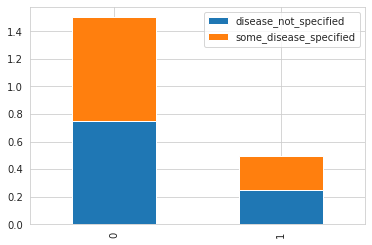

In [22]:
#CLNDN: change 'not_specified' and 'not_provided' as the same category
clndn = pd.concat([data.CLASS.loc[(data.CLNDN=='not_specified') | (data.CLNDN=='not_provided') | (data.CLNDN=='not_specified|not_provided')].value_counts(normalize=True).rename('disease_not_specified'), 
                       data.CLASS.loc[(data.CLNDN!='not_specified') | (data.CLNDN!='not_provided') | (data.CLNDN!='not_specified|not_provided')].value_counts(normalize=True).rename('some_disease_specified')], 
                      axis=1)
clndn.plot.bar(stacked=True)

In [23]:
# Identify duplicates
data.duplicated().sum()

0

### Split data into Train, Validation, Test:
Before data preprocessing, we will split our data to avoid biasing our validation and test pools.

In [24]:
#construct feature matrix 
X = data[['CHROM', 'POS', 'REF', 'ALT', 'AF_ESP', 'CLNDN', 'CLNVI',
       'CLNDISDB', 'CLNVC', 'ORIGIN', 'Allele',
       'IMPACT', 'SYMBOL', 'Feature', 'EXON', 'INTRON',
       'Protein_position', 'Amino_acids',
       'Codons', 'STRAND', 'BAM_EDIT', 'LoFtool',
       'CADD_PHRED', 'BLOSUM62', '2KB_upstream_variant',	
       '3_prime_UTR_variant',	'500B_downstream_variant',	'5_prime_UTR_variant',	
       'frameshift_variant',	'intron_variant',	'missense_variant',	'nonsense',	
       'splice_acceptor_variant',	'splice_donor_variant',	'synonymous_variant', 
       'SIFT_deleterious', 'SIFT_deleterious_low_confidence',	'SIFT_tolerated',	
       'SIFT_tolerated_low_confidence',	'PolyPhen_benign',	'PolyPhen_possibly_damaging',	
       'PolyPhen_probably_damaging', 'PolyPhen_unknown']]
y = data['CLASS']

X.shape, y.shape

((65172, 43), (65172,))

In [25]:
X_train, X_rest, y_train, y_rest = train_test_split(X, y, train_size=0.6, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, train_size=0.2, test_size=0.2, random_state=42)

print('X_train shape:', X_train.shape), print('y_train shape:', y_train.shape)
print('X_val shape:', X_val.shape), print('y_val shape:', y_val.shape)
print('X_test shape:', X_test.shape), print('y_test shape:', y_test.shape)

X_train shape: (39103, 43)
y_train shape: (39103,)
X_val shape: (5213, 43)
y_val shape: (5213,)
X_test shape: (5214, 43)
y_test shape: (5214,)


(None, None)

### Data Processing Pt 2:
Sparse columns removal, outlier detection, imputation, encoding. 

We can search through our data to find columns with low amounts of data, called sparse columns. These can be removed.

In [26]:
numerical_data = X_train.select_dtypes(include='number')
print(numerical_data.head)
numerical_columns = ['POS', 'Protein_position','ORIGIN','LoFtool','CADD_PHRED','EXON','AF_ESP']

<bound method NDFrame.head of              POS  AF_ESP  ORIGIN      EXON  INTRON  Protein_position  STRAND  \
32677   62041947  0.0000       0  0.375000     0.0             445.0    -1.0   
19358   32900742  0.0000       1  0.259259     0.0             208.0     1.0   
36441   38991516  0.0976       1  0.443396     0.0            2500.0     1.0   
1337   128627862  0.0003       1  0.777778     0.0             469.0     1.0   
30170   33434141  0.0000       1  0.500000     0.0             136.0    -1.0   
...          ...     ...     ...       ...     ...               ...     ...   
62570  134381529  0.0000       1  0.150000     0.0              51.0     1.0   
38158   47630392  0.0000       1  0.062500     0.0              21.0     1.0   
860    179606538  0.1809       1  0.132231     0.0            3808.0    -1.0   
15795  108199824  0.0000       1  0.777778     0.0            2389.0     1.0   
56422  152623062  0.0010       1  0.623288     0.0            5828.0    -1.0   

       Lo

In [27]:
#Outlier Detection
data_train = X_train.copy()

sparse_data = []
for col in numerical_data:
  if (data_train[col].quantile(0.01)==data_train[col].quantile(0.25)==data_train[col].mode()[0]):
        sparse_data.append(col)

sparse_data_2 = []
for col in numerical_data:
    if (data_train[col].quantile(0.01)==data_train[col].quantile(0.25)):
        sparse_data_2.append(col)

len(numerical_data), len(sparse_data), len(sparse_data_2)

(39103, 22, 23)

It makes sense to use k-fold here because we have a lot of data, and we want to avoid overfitting. 

In [28]:
#Encoding training data
#write KFold encoder function (ref internet)
class KFoldTargetEncoderTrain(base.BaseEstimator, base.TransformerMixin):
    def __init__(self,colnames,targetName,
                  n_fold=5, verbosity=True,
                  discardOriginal_col=False):
        self.colnames = colnames
        self.targetName = targetName
        self.n_fold = n_fold
        self.verbosity = verbosity
        self.discardOriginal_col = discardOriginal_col
    def fit(self, X, y=None):
        return self
    def transform(self,X):
        assert(type(self.targetName) == str)
        assert(type(self.colnames) == str)
        assert(self.colnames in X.columns)
        assert(self.targetName in X.columns)
        mean_of_target = X[self.targetName].mean()
        kf = KFold(n_splits = self.n_fold, shuffle = False) #, random_state=2022)
        col_mean_name = self.colnames + '_' + 'Kfold_Target_Enc'
        X[col_mean_name] = np.nan
        for tr_ind, val_ind in kf.split(X):
            X_tr, X_val = X.iloc[tr_ind], X.iloc[val_ind]
            X.loc[X.index[val_ind], col_mean_name] = X_val[self.colnames].map(X_tr.groupby(self.colnames)
                                     [self.targetName].mean())
            X[col_mean_name].fillna(mean_of_target, inplace = True)
        if self.verbosity:
            encoded_feature = X[col_mean_name].values
            print('Correlation between the new feature, {} and, {} is {}.'.format(col_mean_name, self.targetName, np.corrcoef(X[self.targetName].values, encoded_feature)[0][1]))
        if self.discardOriginal_col:
            X = X.drop(self.targetName, axis=1)
        return X
#https://medium.com/@pouryaayria/k-fold-target-encoding-dfe9a594874b

In [29]:
#function to fit/transform data to encoder
def StringConverterTrain(data,target_name,variable_list):
    for col in variable_list:
      targetc = KFoldTargetEncoderTrain(col,target_name,n_fold=4)
      new_train = targetc.fit_transform(data)
    return new_train

In [30]:
#define attribute lists to pass into encoder
nominal_columns = ['Amino_acids', 'Codons', 'CLNVI', 'BLOSUM62', 'BAM_EDIT']
nominal_encoding_variable_columns =["REF","ALT","Allele","Feature","SYMBOL", "CLNDISDB","CLNDN"]

In [31]:
#combine training data and run through encoder fit/transform function
df_trial = pd.concat([X_train,y_train],axis=1).copy()
df_output_train = StringConverterTrain(data=df_trial,target_name="CLASS",variable_list=nominal_columns)

Correlation between the new feature, Amino_acids_Kfold_Target_Enc and, CLASS is 0.07155130787579717.
Correlation between the new feature, Codons_Kfold_Target_Enc and, CLASS is 0.051051408501834226.
Correlation between the new feature, CLNVI_Kfold_Target_Enc and, CLASS is 0.005870410576445243.
Correlation between the new feature, BLOSUM62_Kfold_Target_Enc and, CLASS is 0.02612603260811726.
Correlation between the new feature, BAM_EDIT_Kfold_Target_Enc and, CLASS is 0.014053641371129853.


In [32]:
#repeat for nominal_encoding_var attribute list
df_encoding = pd.concat([X_train,y_train],axis=1).copy()
df_encoding_train = StringConverterTrain(data=df_encoding,target_name="CLASS",variable_list=nominal_encoding_variable_columns)

Correlation between the new feature, REF_Kfold_Target_Enc and, CLASS is 0.029708518944878404.
Correlation between the new feature, ALT_Kfold_Target_Enc and, CLASS is 0.024276287909198405.
Correlation between the new feature, Allele_Kfold_Target_Enc and, CLASS is 0.023637638960733866.
Correlation between the new feature, Feature_Kfold_Target_Enc and, CLASS is 0.16230859858113442.
Correlation between the new feature, SYMBOL_Kfold_Target_Enc and, CLASS is 0.16265854611647865.
Correlation between the new feature, CLNDISDB_Kfold_Target_Enc and, CLASS is 0.256757881934838.
Correlation between the new feature, CLNDN_Kfold_Target_Enc and, CLASS is 0.2570705023283095.


In [33]:
for item in nominal_columns:
  X_train[item] = df_output_train[item+"_Kfold_Target_Enc"]

In [34]:
for item in nominal_encoding_variable_columns:
  X_train[item] = df_encoding_train[item+"_Kfold_Target_Enc"]

In [35]:
# create test dataset KFold encoder
class KFoldTargetEncoderTest(base.BaseEstimator, base.TransformerMixin):
    def __init__(self,train,colNames,encodedName):
        self.train = train
        self.colNames = colNames
        self.encodedName = encodedName
        
    def fit(self, X, y=None):
        return self
    def transform(self,X):
        mean =  self.train[[self.colNames, self.encodedName]].groupby(self.colNames).mean().reset_index() 
        dd = {}
        for index, row in mean.iterrows():
            dd[row[self.colNames]] = row[self.encodedName]
        X[self.encodedName] = X[self.colNames]
        X = X.replace({self.encodedName: dd})
        return X

In [36]:
df_output_test = X_test.copy()
mean_of_target = df_output_train['CLASS'].copy().mean()
target_mean_list = nominal_columns                                                 
for col in target_mean_list:
    df_output_test[col] = df_output_test[col].map(df_output_train.groupby(col)[col+'_Kfold_Target_Enc'].mean())
    df_output_test[col].fillna(mean_of_target, inplace = True)

In [37]:
X_test[nominal_columns] = df_output_test[nominal_columns]

X_test_encoder = X_test.copy()
mean_of_target = df_encoding_train['CLASS'].copy().mean()
target_mean_list = nominal_encoding_variable_columns   

for col in target_mean_list:
  X_test_encoder[col+'_Kfold_Target_Enc'] = X_test_encoder[col].map(df_encoding_train.groupby(col)[col+'_Kfold_Target_Enc'].mean())
  X_test_encoder[col+'_Kfold_Target_Enc'].fillna(mean_of_target, inplace = True)

for item in nominal_encoding_variable_columns:
  X_test[item] = X_test_encoder[item+"_Kfold_Target_Enc"]

In [38]:
#define scaling function (reference online project)
def MBI(df,columns,train_or_test,lst_numerical):

  data_binary_encoded=df.copy()
  le=LabelEncoder()

  for col in columns:
    if(train_or_test == "test"):
      le.fit(X_train[col].copy().astype(str))
      data_binary_encoded[col]=le.transform(df[col].copy().astype(str))
    else:
      data_binary_encoded[col] = le.fit_transform(df[col].copy().astype(str))
      
  data_scaled=data_binary_encoded.copy()

  for col in numerical_columns:
    scaler = StandardScaler()
    if(train_or_test == "test"):
      scaler.fit(np.array(X_train.loc[:,col]).reshape(-1,1))
      data_scaled.loc[:,col] = scaler.transform(np.array(data_scaled.loc[:,col]).reshape(-1,1))
    else:
      data_scaled.loc[:,col] = scaler.fit_transform(np.array(data_scaled.loc[:,col]).reshape(-1,1))

  for col in lst_numerical:
    target_dropped_fullcases = data_scaled.drop(col,axis=1).loc[:,list(set(['POS', 'REF', 'ALT', 'AF_ESP', 'CLNVC', 'CLASS', 'Allele', 'IMPACT', 'CHROM', 'KEY']
                                                                           +['CADD_PHRED','EXON', 'SYMBOL', 'STRAND', 'Feature'])-
                                                                                  set(["CLASS","KEY","CLNHGVS"]))].copy()
    
    target = data_scaled.loc[:,col]
    null_mask = target.isna()
    print(col)
    
  print(data_scaled.loc[:,lst_numerical].isnull().sum());
  return data_scaled

In [39]:
#define numerical and encoded attribute columns to pass to MBI function
lst_numerical = ['Protein_position', 'LoFtool', 'SIFT_deleterious', 'SIFT_deleterious_low_confidence', 'SIFT_tolerated',
       'SIFT_tolerated_low_confidence', 'PolyPhen_benign', 'PolyPhen_possibly_damaging', 'PolyPhen_probably_damaging', 'PolyPhen_unknown']
encoding_col_list =["CHROM","CLNVC","IMPACT"]

#use MBI function to scale (StandardScaler)
X_train_scaled = MBI(X_train,encoding_col_list,"train",lst_numerical)

Protein_position
LoFtool
SIFT_deleterious
SIFT_deleterious_low_confidence
SIFT_tolerated
SIFT_tolerated_low_confidence
PolyPhen_benign
PolyPhen_possibly_damaging
PolyPhen_probably_damaging
PolyPhen_unknown
Protein_position                   5997
LoFtool                            2539
SIFT_deleterious                      0
SIFT_deleterious_low_confidence       0
SIFT_tolerated                        0
SIFT_tolerated_low_confidence         0
PolyPhen_benign                       0
PolyPhen_possibly_damaging            0
PolyPhen_probably_damaging            0
PolyPhen_unknown                      0
dtype: int64


Imputation:

In [40]:
# create imputation function (referenced from internet)
def SimpleImputer(df,variable_list):
  for col in variable_list:
    if(col in numerical_columns):
      print("Total null values: {}".format(df[[str(col)]].isnull().sum()))

      average = float(df[col].mean())
      std = float(df[col].std())
      count_nan = int(df[col].isnull().sum())
      rand = np.random.normal(loc=average,scale=std,size =count_nan)
      slice_col = pd.Series(df[col].copy())
      slice_col[pd.isnull(slice_col)] = rand
      df[col] = slice_col

      print("Numerical variable {} have been imputed.".format(col))

    else:
      print("Total null values: {}".format(df[[str(col)]].isnull().sum()))
      df.loc[df.loc[:,col].isnull(),col] = np.random.choice(sorted(list(df.loc[:,col].dropna().unique())),
                                                            size=int(df.loc[df.loc[:,col].isnull(),col].shape[0]),
                                                            p=[pd.Series(df.groupby(col).size()/df.loc[:,col].dropna().shape[0]).iloc[i] for i in 
                                                               np.arange(0,len(df.loc[:,col].dropna().unique()))])
      
      print("Categorical variable {} have been imputed.".format(col))

In [41]:
#pass attributes with low amounts of missing values through it
SimpleImputer(X_train_scaled, ['CADD_PHRED','EXON', 'SYMBOL', 'STRAND', 'Feature', 'LoFtool'])
SimpleImputer(X_train_scaled, ['2KB_upstream_variant', '3_prime_UTR_variant', '500B_downstream_variant', '5_prime_UTR_variant', 
'frameshift_variant', 'intron_variant', 'missense_variant', 'nonsense', 'splice_acceptor_variant', 
'splice_donor_variant', 'synonymous_variant'])

Total null values: CADD_PHRED    679
dtype: int64
Numerical variable CADD_PHRED have been imputed.
Total null values: EXON    0
dtype: int64
Numerical variable EXON have been imputed.
Total null values: SYMBOL    0
dtype: int64
Categorical variable SYMBOL have been imputed.
Total null values: STRAND    0
dtype: int64
Categorical variable STRAND have been imputed.
Total null values: Feature    0
dtype: int64
Categorical variable Feature have been imputed.
Total null values: LoFtool    2539
dtype: int64
Numerical variable LoFtool have been imputed.
Total null values: 2KB_upstream_variant    503
dtype: int64
Categorical variable 2KB_upstream_variant have been imputed.
Total null values: 3_prime_UTR_variant    503
dtype: int64
Categorical variable 3_prime_UTR_variant have been imputed.
Total null values: 500B_downstream_variant    503
dtype: int64
Categorical variable 500B_downstream_variant have been imputed.
Total null values: 5_prime_UTR_variant    503
dtype: int64
Categorical variable 

In [42]:
#check imputation with a few instances:
print('Null values in X_train_scaled[CADD_PHRED]', X_train_scaled['CADD_PHRED'].isnull().sum())
print('Null values in X_train_scaled[STRAND]', X_train_scaled['STRAND'].isnull().sum())
print('Null values in X_train_scaled[Feature]', X_train_scaled['Feature'].isnull().sum())

Null values in X_train_scaled[CADD_PHRED] 0
Null values in X_train_scaled[STRAND] 0
Null values in X_train_scaled[Feature] 0


In [44]:
#Last cleaning of dataset before model training
print("Any NaN before cleaning:", np.any(np.isnan(X_train_scaled)))
print("All finite before cleaning:", np.all(np.isfinite(X_train_scaled)))

#X_train_scaled = np.nan_to_num(X_train_scaled)

X_train_scaled.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train_scaled.fillna(0, inplace=True)

'''def clean_dataset(df):
    assert isinstance(df, pd.DataFrame)
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)
clean_dataset(X_train_scaled)'''

print("Any NaN after cleaning:", np.any(np.isnan(X_train_scaled)))
print("All finite after cleaning:", np.all(np.isfinite(X_train_scaled)))

Any NaN before cleaning: True
All finite before cleaning: False
Any NaN after cleaning: False
All finite after cleaning: True


In [45]:
#Check data is ready for model training/evaluation
pd.set_option('display.max_columns', None)
X_train_scaled.head(5)

,CHROM,POS,REF,ALT,AF_ESP,CLNDN,CLNVI,CLNDISDB,CLNVC,ORIGIN,Allele,IMPACT,SYMBOL,Feature,EXON,INTRON,Protein_position,Amino_acids,Codons,STRAND,BAM_EDIT,LoFtool,CADD_PHRED,BLOSUM62,2KB_upstream_variant,3_prime_UTR_variant,500B_downstream_variant,5_prime_UTR_variant,frameshift_variant,intron_variant,missense_variant,nonsense,splice_acceptor_variant,splice_donor_variant,synonymous_variant,SIFT_deleterious,SIFT_deleterious_low_confidence,SIFT_tolerated,SIFT_tolerated_low_confidence,PolyPhen_benign,PolyPhen_possibly_damaging,PolyPhen_probably_damaging,PolyPhen_unknown
32677,8,-0.257541,63,55,-0.250798,0.251976,0.251976,0.251976,6,-0.228833,31,2,0.244444,0.244444,-0.349522,0.0,-0.270870,0.218045,0.209302,-1.0,0.251976,-0.938350,1.502733,0.273383,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0
19358,4,-0.744999,54,39,-0.250798,0.351852,0.251976,0.351852,6,-0.060779,19,2,0.321995,0.321995,-0.689118,0.0,-0.325952,0.384615,0.454545,1.0,0.249895,-0.706189,1.088185,0.276813,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0
36441,10,-0.643116,66,55,1.437035,0.333333,0.251976,0.333333,6,-0.060779,31,1,0.299213,0.299213,-0.148841,0.0,0.206741,0.267530,0.269481,1.0,0.251976,-0.947317,-0.159145,0.251976,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0
1337,15,0.856270,63,52,-0.245610,0.346939,0.251976,0.346939,6,-0.060779,29,2,0.251976,0.251976,0.832270,0.0,-0.265292,0.290488,0.291990,1.0,0.249895,-0.489196,0.931578,0.276813,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,0,0,0,1,0,0,0
30170,8,-0.736077,63,52,-0.250798,0.140097,0.251976,0.140097,6,-0.060779,29,2,0.163462,0.163462,0.017241,0.0,-0.342686,0.366337,0.311688,-1.0,0.249895,-2.044125,-0.367340,0.332464,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1,0,0,0,0,1,0,0


In [46]:
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39103 entries, 32677 to 56422
Data columns (total 43 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   CHROM                            39103 non-null  int64  
 1   POS                              39103 non-null  float64
 2   REF                              39103 non-null  int64  
 3   ALT                              39103 non-null  int64  
 4   AF_ESP                           39103 non-null  float64
 5   CLNDN                            39103 non-null  float64
 6   CLNVI                            39103 non-null  float64
 7   CLNDISDB                         39103 non-null  float64
 8   CLNVC                            39103 non-null  int64  
 9   ORIGIN                           39103 non-null  float64
 10  Allele                           39103 non-null  int64  
 11  IMPACT                           39103 non-null  int64  
 12  SYMBOL        

### Model Training

Models Selection:
- Logistic Regression
- KNeighbors Classifier?
- Decision Tree
- Gradient Boosting
- XGBoost
- Hist Gradient Boost

For this analysis, we choose LogReg, Gradient Boost, and XG Boost. The latter two because they are most likely to be the best models for this dataset, the former because it is a classic classification model. 

In [52]:
#Logistic Regression
clf = LogisticRegression()
clf.fit(X_train_scaled, y_train)

y_preds_LR = clf.predict_proba(X_test)
preds_LR = y_preds_LR[:,1]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


ValueError: ignored

In [ ]:
#Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
gradient_boosting_clf = GradientBoostingClassifier(n_estimators=100, max_depth=7, random_state=42).fit(X_train_scaled, y_train)

y_preds_GB = gradient_boosting_clf.predict_proba(X_test)
preds_GB = y_preds_GB[:,1]

In [ ]:
#XGboost model
import xgboost as xgb
xgb_model = xgb.XGBClassifier(n_estimators=150,random_state=42,booster="gbtree",base_score=0.8,colsample_bylevel=0.9009229642844634,gamma=0.49967765132613584,
                        max_depth=6,min_child_weight=7,reg_lambda=0.27611902459972926,subsample=0.9300916052594785) #parameter values from internet analysis
xgb_model.fit(X_train_scaled, y_train)

y_preds_XG = xgb_model.predict_proba(X_test)
preds_XG = y_preds_XG[:,1]

### Model Performance Summary and Analysis:

In [ ]:
#Log Reg Model Evaluation

#Confusion Matrix
print("Logistic Regression Classifier Confusion Matrix:", confusion_matrix(y_true=y_test, y_pred=y_pred_LR))

#ROC/AUC
fpr, tpr, _ = metrics.roc_curve(y_test, preds_LR)
auc_score = metrics.auc(fpr, tpr)
accur_roc_score.loc['Logistic_regression'] = [auc_score]

plt.subplots(figsize=(8, 6))
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='Logistic R. AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')

lt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

#General classification report
print(classification_report(y_true=y_test, y_pred=y_preds_LR))

In [ ]:
#GB classifier Evaluation

#Confusion Matrix
print("Gradient Boost Classifier Confusion Matrix:", confusion_matrix(y_true=y_test, y_pred=y_pred_GB))

#ROC/AUC
fpr, tpr, _ = metrics.roc_curve(y_test, preds_GB)

auc_score = metrics.auc(fpr, tpr)
accur_roc_score.loc['GradientBoostingClassifier'] = [auc_score]

plt.subplots()
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='GradientBoosting Classifier AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend()
plt.show()

#General classification report
print(classification_report(y_true=y_test, y_pred=y_preds_GB))

In [ ]:
#XGboost Evaluation

#Confusion Matrix
print("XG Boost Classifier Confusion Matrix:", confusion_matrix(y_true=y_test, y_pred=y_pred_XG))

#ROC/AUC
fpr, tpr, _ = metrics.roc_curve(y_test, preds_XG)

auc_score = metrics.auc(fpr, tpr)
accur_roc_score.loc['XGBoost_Classifier'] = [auc_score]

plt.subplots()
plt.title('ROC Curve')
plt.plot(fpr, tpr, label='XGBoost Classifier AUC = {:.2f}'.format(auc_score))
plt.plot([0,1],[0,1],'r--')

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend()
plt.show()

#General classification report
print(classification_report(y_true=y_test, y_pred=y_preds_XG))

Now, we may alter parameters and retest on the validation sample. 

In [ ]:
#Parameter tuning:

In [ ]:
#Comparison of performance between pre-parameter adjustment and post-adjustment:

### Error Analysis and Conclusion

The data preprocessing on this dataset is complex, and I was unable to prepare the data properly in time for the models to run -- I ended up getting a convergence waring and being unable to figure out how to solve it. One of the issues that I ran into was the trade-off between not having data contamination by not altering validation/test data, and being able to encode all data at once and see relationships in the variables earlier on in data visualization via a heatmap (by imputing/encoding in the whole dataset). My compromise was to perform all imputation and variable removal in the training data, but do minimal encoding (especially text encoding) in all the data, as regardless of the model text would need to be encoded. I used KFold cross-validation to perform target encoding on some variables, which requires fit/transformation and separate train/test sets, and I performed that within the training set to prevent data contamination. 

I cannot speak to the ability of these models with my data preparation, but given other people's attempts at working with this dataset, it appears that the GB model has the highest ROC/AUC score. Depending on whether feature importance was weighted, XGBoost also was very high. Other models I did not attempt that seemed to work well in other pipelines include LGBM Classifier and Hist-Gradient Boosting Classifier.

In the future, I could streamline my datapre-processing by using the sklearn.pipeline function. This notebook is not streamlined and takes a while to load. The way I store data in train/test and in copies changes throughout the notebook, and standarizing that would aid in smooth running. I need to look more in-depth at my code to see what is causing the Convergence Warning, as this is significant. Finally, once my models are functional, I would perform proper evaluation analysis and validation paramater tuning. 